## 用于测试各种核方法或者其他计算propensity scores的方法


In [1]:
from sklearn import linear_model
from scipy.sparse import coo_matrix
from scipy.stats import ttest_rel, binom
from scipy.stats import chi2
import numpy as np
from math import log
import sys

import sklearn.metrics.pairwise
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
filename = "data/data1_movie.txt"
param_reg = 1.0
param_thresh = 100000.0

word_docs = {}
docs_word = []
vocab = {}
l = 0
iter_num = 500

for line in open(filename):
    if l >= iter_num:
        break
    tokens = line.strip().split()
    docs_word.append(tokens[1 : ])
    for word in set(tokens[1 : ]):
        if word not in vocab:
            vocab[word] = len(vocab)
        if word not in word_docs:
            word_docs[word] = []
        word_docs[word].append(l)
    
    l += 1
    
L = l
V = len(vocab)

print("%d documents, %d distinct word types" % (L, V))

500 documents, 6927 distinct word types


In [3]:
vocab

{'it': 0,
 'eyebrow': 1,
 'had': 2,
 'isn': 3,
 'well': 4,
 'here': 5,
 'but': 6,
 'not': 7,
 'to': 8,
 'acting': 9,
 'great': 10,
 'part': 11,
 'more': 12,
 'blew': 13,
 'superhero': 14,
 'love': 15,
 'll': 16,
 'fan': 17,
 'and': 18,
 'with': 19,
 'story': 20,
 'eat': 21,
 'cast': 22,
 'away': 23,
 'effects': 24,
 'again': 25,
 'times': 26,
 'plenty': 27,
 'serkis': 28,
 'hopefully': 29,
 'booked': 30,
 'renewed': 31,
 'see': 32,
 'words': 33,
 're': 34,
 'saw': 35,
 'if': 36,
 'awesome': 37,
 'even': 38,
 '10': 39,
 'few': 40,
 'admit': 41,
 'when': 42,
 'raised': 43,
 'known': 44,
 'you': 45,
 'genuinely': 46,
 'fast': 47,
 'that': 48,
 'movies': 49,
 've': 50,
 'of': 51,
 'throughout': 52,
 'this': 53,
 'surprisingly': 54,
 'already': 55,
 'music': 56,
 'gritty': 57,
 'film': 58,
 'pattinson': 59,
 'somehow': 60,
 'special': 61,
 'faces': 62,
 'felt': 63,
 'fantastic': 64,
 'an': 65,
 'will': 66,
 'me': 67,
 'andy': 68,
 'play': 69,
 'my': 70,
 'franchise': 71,
 'he': 72,
 'was': 

In [4]:
word_docs

{'it': [0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  42,
  43,
  44,
  45,
  46,
  47,
  49,
  50,
  51,
  52,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  63,
  65,
  66,
  69,
  70,
  71,
  72,
  73,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  85,
  86,
  87,
  88,
  89,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  99,
  100,
  101,
  102,
  103,
  104,
  106,
  107,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  130,
  131,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  164,
  165,
  167,
  168,
  169,
  170,
  171,
  173,
  174,
  177,
  179,
  180,
  181,
  182,
  184,
  185,
  187,
  188,
  

In [5]:
treatment = "great"

rows = []
cols = []
values = []
y = []

for line in range(iter_num):

    contains_treatment = 0
    for word in docs_word[line]:
        if word == treatment:
            contains_treatment = 1
        else:
            rows.append(line)
            cols.append(vocab[word])
            values.append(1.0)
    y.append(contains_treatment)
    
x = coo_matrix((values, (rows, cols)), shape = (iter_num, V)).toarray()
print(x.shape)

(500, 6927)


In [6]:
class Model(object):
    def __init__(self, kernel = "linear", C = 1.0, gamma = 'auto', degree = 3, coef0 = 0., anova = False, percentile = 10):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.anova = anova
        self.percentile = percentile
        if anova:
            self.model = Pipeline(
                [
                    ("anova", SelectPercentile()),
                    ("scaler", StandardScaler()),
                    ("svc", svm.SVC(kernel = self.kernel, C = self.C, gamma = self.gamma, 
                                    degree = self.degree, coef0 = self.coef0, probability = True))
                ]
            )
        else:
            self.model = svm.SVC(kernel = self.kernel, C = self.C, gamma = self.gamma, 
                                 degree = self.degree, coef0 = self.coef0, probability = True)
        
    def fit(self, x, y):
        self.model.fit(x, y)
        
    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [7]:
def plt_hist(scores, y, coef = np.zeros((4, 2)), output = False):
    plt.figure(figsize=(15,7))
    plt.hist(scores[[i for i, x in zip(range(len(y)), y) if x == 0]], bins=50, label='Negatives')
    plt.hist(scores[[i for i, x in zip(range(len(y)), y) if x == 1]], bins=50, label='Positives', alpha = 0.7, color='r')
    plt.xlabel('Probability of being Positive Class', fontsize=25)
    plt.ylabel('Number of records in each bucket', fontsize=25)
    plt.legend(fontsize=15)
    plt.tick_params(axis='both', labelsize=25, pad=5)
    if output:
        coef_str = '_'.join('_'.join(str(int(x)) for x in line) for line in coef)
        plt.title(coef_str)
        imagepath = 'images/coef' + coef_str + '.png'
        plt.savefig(imagepath)
    else:
        plt.show() 

## Logistic Regression

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


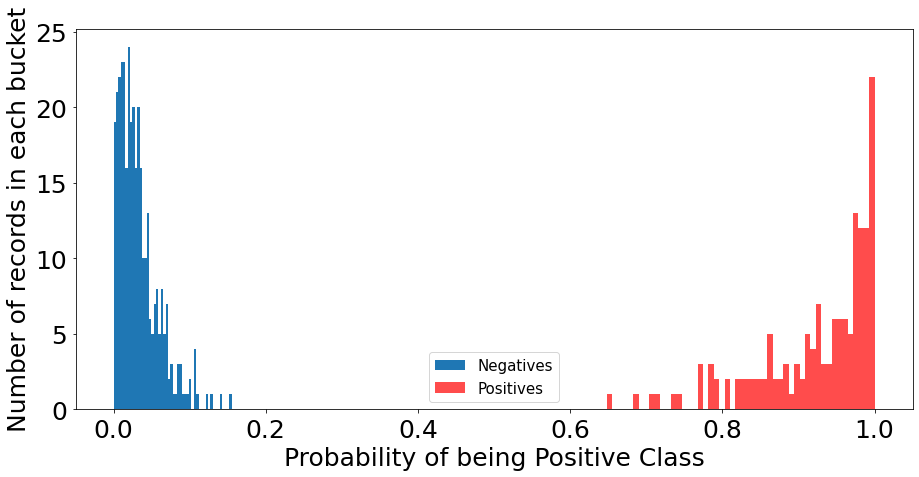

In [8]:
initial_model = linear_model.LogisticRegression()
initial_model.fit(x, y)
initial_scores = initial_model.predict_proba(x)[ : , 1]
plt_hist(initial_scores, y)

## Gaussian kernel

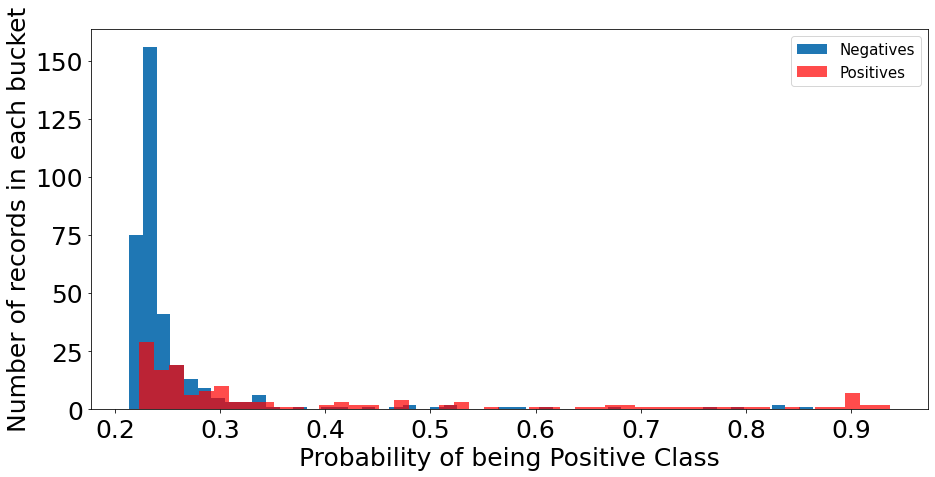

In [9]:
model = Model(kernel = 'rbf')
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Polynomial kernel (default: degree = 3)

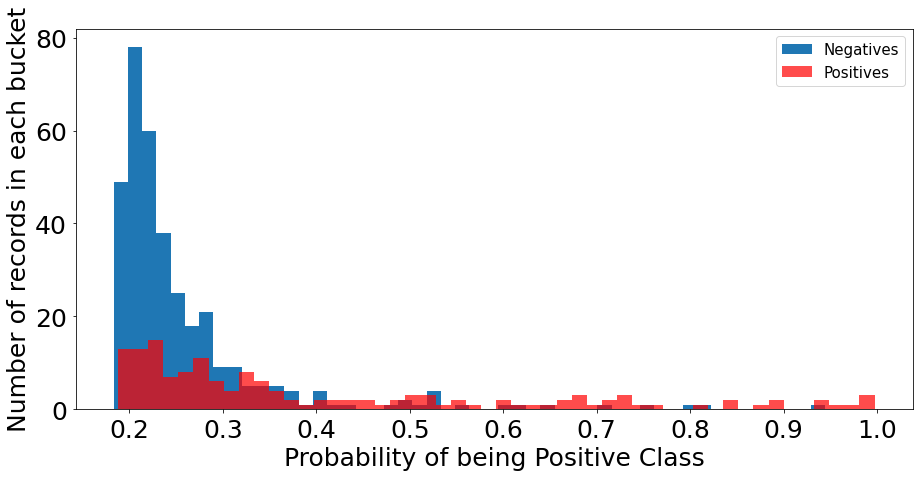

In [10]:
model = Model(kernel = 'poly', degree = 1)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Sigmoid kernel

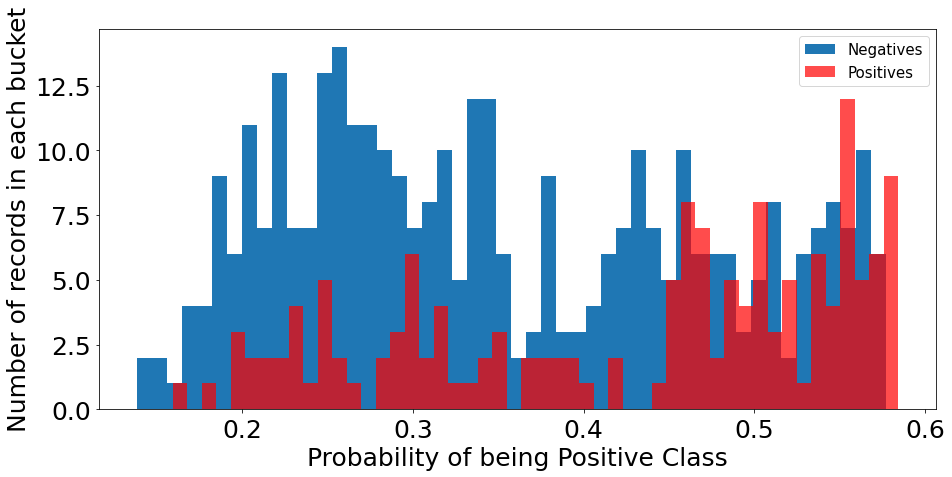

In [11]:
model = Model(kernel = 'sigmoid', gamma = 0.001, coef0 = 10)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

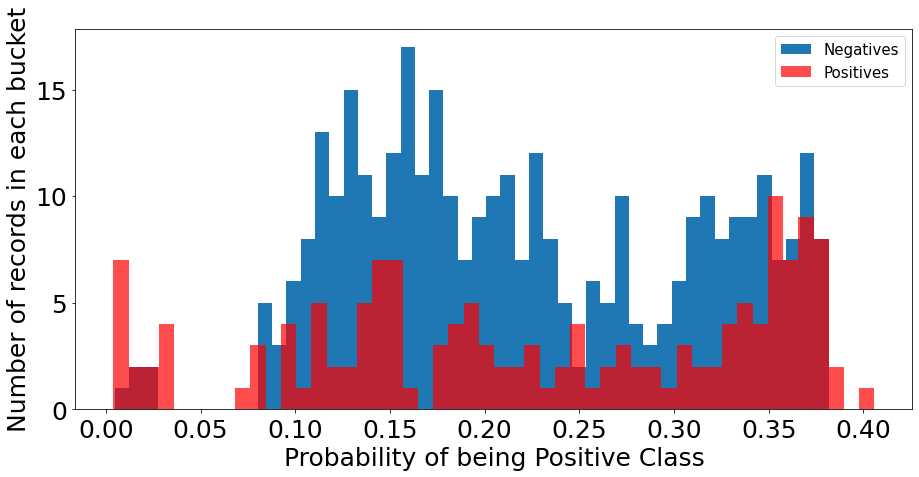

In [12]:
model = Model(kernel = 'sigmoid', gamma = 0.0009)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Linear kernel

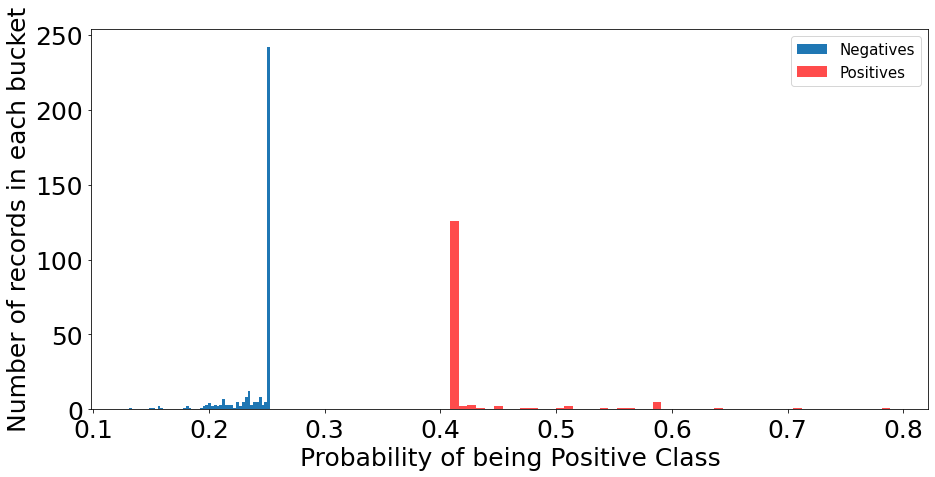

In [13]:
model = Model()
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Gaussian kernel with LogisticRegression

(500, 6927)


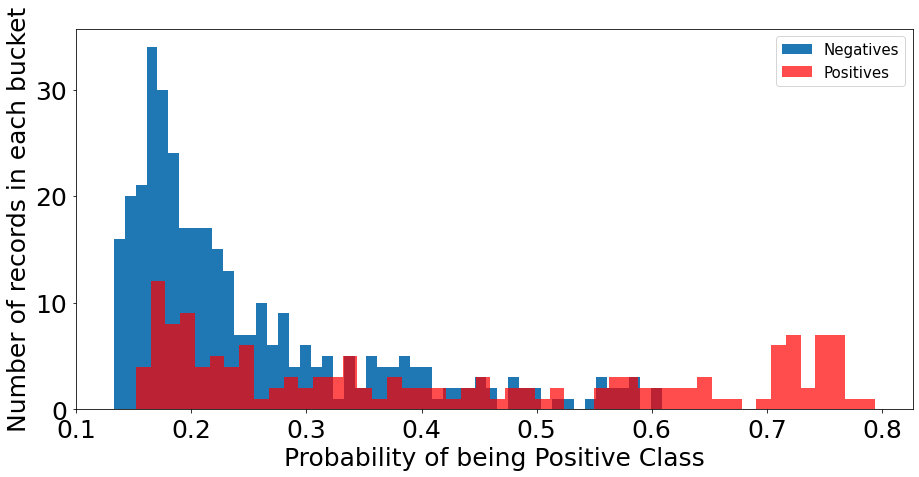

In [14]:
model = linear_model.LogisticRegression(C=1)
print(x.shape)
new_x = sklearn.metrics.pairwise.rbf_kernel(x, x, gamma = 0.0015)
model.fit(new_x, y)
scores = model.predict_proba(new_x)[ : , 1]
plt_hist(scores, y)

## Polynomial kernel with LogisticRegression

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


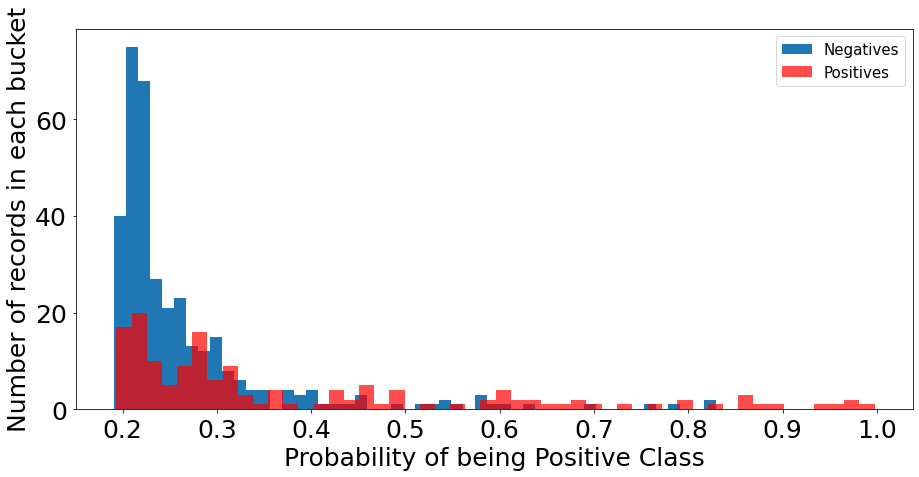

In [15]:
model = linear_model.LogisticRegression(C=0.1)
x_ = sklearn.metrics.pairwise.polynomial_kernel(x, x, degree = 3)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Linear kernel with LogisticRegression

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


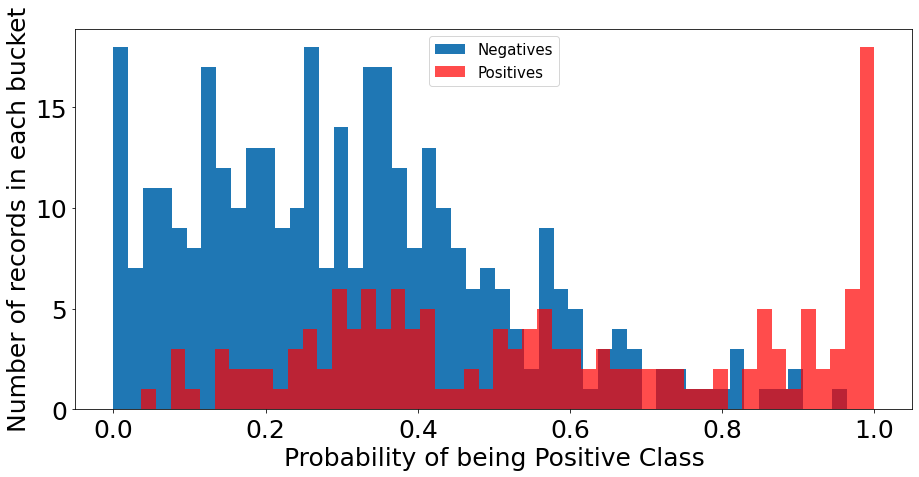

In [16]:
model = linear_model.LogisticRegression(C=1)
x_ = sklearn.metrics.pairwise.linear_kernel(x, x)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Sigmoid kernel with LogisticRegression

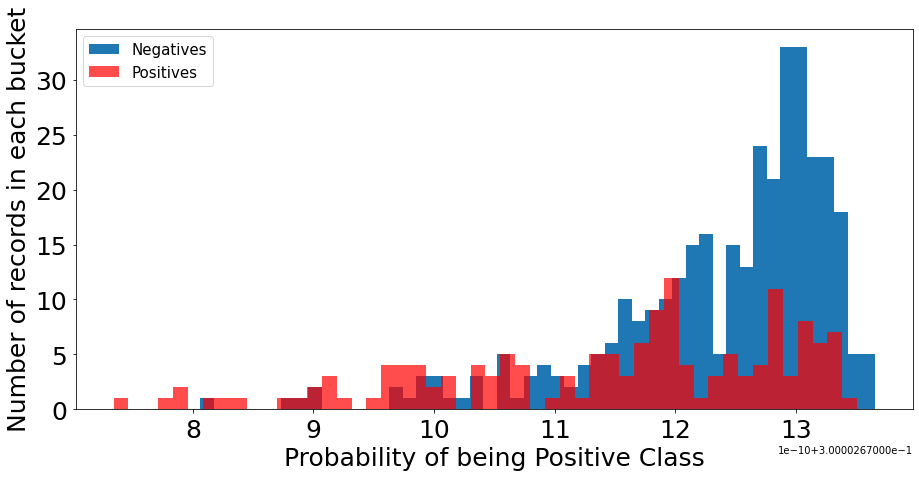

In [22]:
model = linear_model.LogisticRegression(C=1)
x_ = sklearn.metrics.pairwise.sigmoid_kernel(x, x, gamma = 0.001, coef0 = 10)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Linear combination of kernels

In [18]:
model = linear_model.LogisticRegression(C=1)
x_rbf = sklearn.metrics.pairwise.rbf_kernel(x, x, gamma = 0.0015)
x_linear = sklearn.metrics.pairwise.linear_kernel(x, x)
x_poly = sklearn.metrics.pairwise.polynomial_kernel(x, x, degree = 2)
x_sigmoid = sklearn.metrics.pairwise.sigmoid_kernel(x, x, gamma = 0.0001)

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


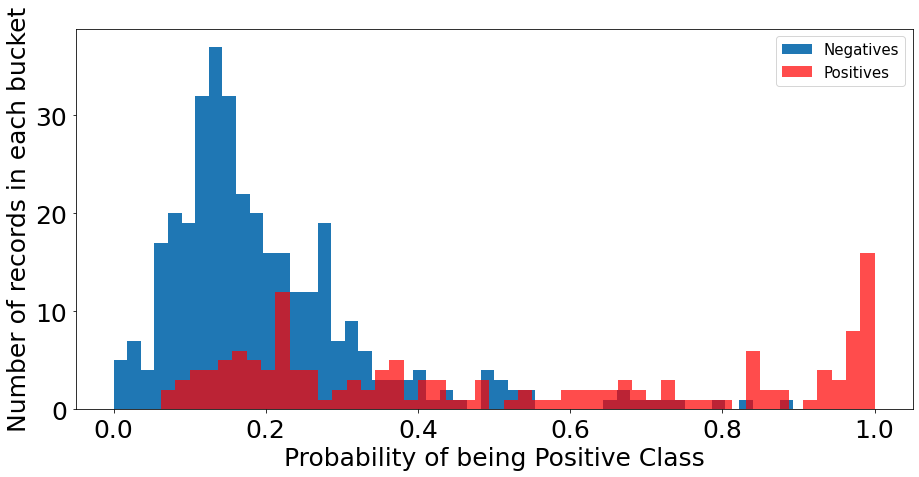

In [19]:
a = 1
b = 1
c = 1
d = 1
x_new = a * x_rbf + b * x_linear + c * x_poly + d * x_sigmoid
model.fit(x_new, y)
scores = model.predict_proba(x_new)[ : , 1]
plt_hist(scores, y)

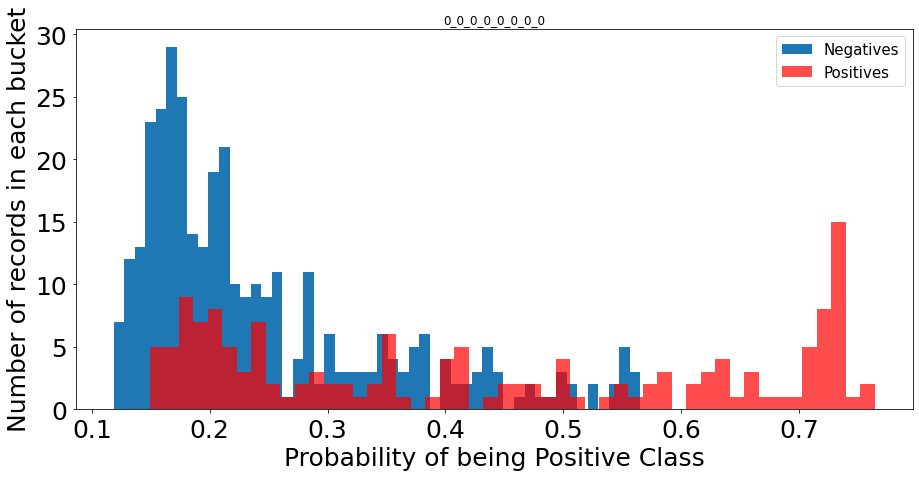

In [20]:
x_new = a * x_rbf ** 1.5
model.fit(x_new, y)
scores = model.predict_proba(x_new)[ : , 1]
plt_hist(scores, y, output = True)

In [21]:
# for a in range(1, 4):
#     for b in range(1, 4):
#         for c in range(1, 4):
#             for d in range(1, 4):
#                 for e in range(1, 4):
#                     for f in range(1, 4):
#                         for g in range(1, 4):
#                             for h in range(1, 4):
#                                 x_new = a * x_rbf ** b + c * x_linear ** d + e * x_poly ** f + g * x_sigmoid ** h
#                                 model.fit(x_new, y)
#                                 scores = model.predict_proba(x_new)[ : , 1]
#                                 coef = np.array([a, b, c, d, e, f, g, h]).reshape(4, 2)
#                                 plt_hist(scores, y, coef = coef, output = True)